<a href="https://colab.research.google.com/github/SirMeows/py-ml-mand-2-cnn-flowers/blob/main/cnn_image_recognition_flowers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [86]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pathlib

from sklearn.metrics import confusion_matrix, accuracy_score
from keras.preprocessing import image
from keras.backend import reverse
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Rescaling, RandomFlip,RandomRotation, RandomZoom
from keras.optimizers import Adam
from keras.utils import load_img
from keras.utils import img_to_array
from keras.utils import get_file
from keras.utils import image_dataset_from_directory #  https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

In [64]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [65]:
dataset_url = "http://download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob('*/*.jpg')))
print(F'{data_dir} contains {image_count} images')

/root/.keras/datasets/flower_photos contains 3670 images


In [99]:
batch_size=32
color_mode='rgb'
crop_to_aspect_ratio=True #resize the images without aspect ratio distortion
epochs=5
img_height=256
img_width=256
interploration='bicubic' #interpolation method used when resizing images
kernel_size = (3,3)
labels='inferred'
label_mode='categorical' # labels are encoded as a categorical vector
no_of_filters=28
optimizer=Adam(learning_rate=0.001)
seed=42
shuffle=True
validation_split=0.1

In [77]:
def make_dataset(subset_arg):
  return image_dataset_from_directory(
    data_dir,
    labels=labels,
    label_mode=label_mode, 
    color_mode=color_mode,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=shuffle,
    seed=seed,
    validation_split=validation_split,
    interpolation=interploration, 
    crop_to_aspect_ratio=crop_to_aspect_ratio,
    subset=subset_arg,
  )

In [68]:
train_set = make_dataset('training')
val_set = make_dataset('validation')

Found 3670 files belonging to 5 classes.
Using 3303 files for training.
Found 3670 files belonging to 5 classes.
Using 367 files for validation.


In [69]:
class_names=train_set.class_names
no_of_classes=len(class_names)

In [87]:
model = Sequential([
    Rescaling(1./255),
    RandomFlip('horizontal'),
    RandomRotation(0.1),
    RandomZoom(0.1),
    Conv2D(no_of_filters, kernel_size, strides=2, activation='relu'),
    MaxPool2D(),
    Conv2D(no_of_filters, kernel_size, strides=2, activation='relu'),
    MaxPool2D(),
    Conv2D(no_of_filters, kernel_size, strides=2, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(units=500, activation='relu'),
    Dense(no_of_classes, activation='softmax')
])

In [88]:
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

In [103]:
history = model.fit(x=train_set, validation_data=val_set, epochs=epochs)

Epoch 1/5
104/104 [==============================] - 80s 759ms/step - loss: 0.7477 - categorical_accuracy: 0.7087 - val_loss: 0.8227 - val_categorical_accuracy: 0.6621
Epoch 2/5
104/104 [==============================] - 80s 759ms/step - loss: 0.7220 - categorical_accuracy: 0.7203 - val_loss: 0.8092 - val_categorical_accuracy: 0.6866
Epoch 3/5
104/104 [==============================] - 84s 796ms/step - loss: 0.7190 - categorical_accuracy: 0.7196 - val_loss: 0.7826 - val_categorical_accuracy: 0.6948
Epoch 4/5
104/104 [==============================] - 80s 759ms/step - loss: 0.6907 - categorical_accuracy: 0.7296 - val_loss: 0.7281 - val_categorical_accuracy: 0.7411
Epoch 5/5
104/104 [==============================] - 80s 762ms/step - loss: 0.6643 - categorical_accuracy: 0.7357 - val_loss: 0.7541 - val_categorical_accuracy: 0.7166


In [104]:
validation_result = model.evaluate(val_set)

12/12 [==============================] - 3s 141ms/step - loss: 0.7541 - categorical_accuracy: 0.7166


In [105]:
print(history.history.keys())
#print(validation_result.history.keys())

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


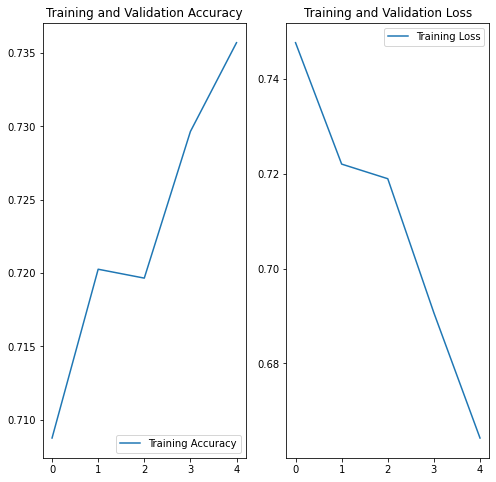

In [106]:
# https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb#scrollTo=jWnopEChMMCn&line=6&uniqifier=1

acc = history.history['categorical_accuracy']
#val_acc = history.history['val_accuracy']

loss = history.history['loss']
#val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
#plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
#plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
def print_result(class_names, result):
  
  res_dict = dict(zip(class_names, result[0]))
  res_sorted = dict(sorted(res_dict.items(), key=lambda item: item[1], reverse=True))

  for k, v in res_sorted.items():
      print(f'{k.ljust(20)} : {v:.5f}')

In [ ]:
@tf.autograph.experimental.do_not_convert
def single_img_predict(img_path):
  test_image = load_img(img_path, target_size=[img_height, img_width], color_mode=color_mode)
  test_image = img_to_array(test_image)
  test_image = np.expand_dims(test_image,axis=0)

  result = model.predict(test_image/255.0)

  print_result(class_names, result)

In [ ]:
print('daisy')
single_img_predict('/root/.keras/datasets/flower_photos/daisy/1354396826_2868631432_m.jpg')
print('')
print('dandelion')
single_img_predict('/root/.keras/datasets/flower_photos/dandelion/8647874151_aac8db2588_m.jpg')
print('')
print('roses')
single_img_predict('/root/.keras/datasets/flower_photos/roses/3576488381_611f3446e0_n.jpg')
print('')
print('sunflowers')
single_img_predict('/root/.keras/datasets/flower_photos/sunflowers/6122711533_2c219f0392_n.jpg')
print('')
print('tulips')
single_img_predict('/root/.keras/datasets/flower_photos/tulips/518256494_368a72db37.jpg')